<a href="https://colab.research.google.com/github/wkabbani/pytorch-playground/blob/main/huggingface-course/Unit01_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Unit01.02

## 02.00. Setup

In [1]:
!pip install diffusers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 14.3 MB/s eta 0:00:00


In [3]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device, torch.__version__

(device(type='cuda'), '1.13.0+cu116')

## 02.01. Data

In [4]:
dataset = torchvision.datasets.MNIST(root="mnist/", download=True, train=True, transform=torchvision.transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



In [5]:
train_dl = DataLoader(dataset, shuffle=True, batch_size=8)

In [6]:
x, y = next(iter(train_dl))
print(x.shape, y.shape)

torch.Size([8, 1, 28, 28]) torch.Size([8])


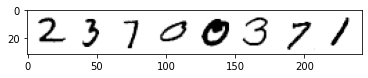

In [8]:
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

## 02.02. The Corruption Process

In [16]:
def corrupt(x, noise_amount):
  noise = torch.rand_like(x)
  noise_amount = noise_amount.view(-1, 1, 1, 1)
  return noise*noise_amount + x*(1-noise_amount)

In [17]:
amount = torch.linspace(0, 1, x.shape[0])

In [18]:
noised_x = corrupt(x, amount)

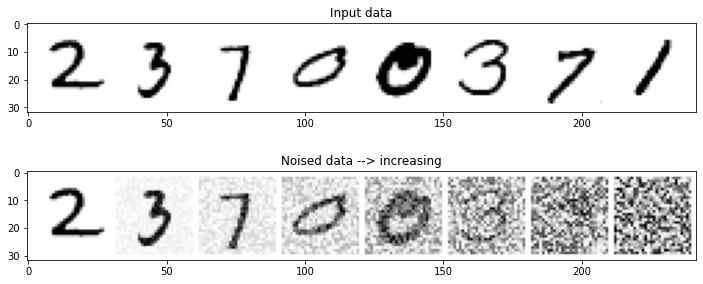

In [20]:
fix, axes = plt.subplots(2, 1, figsize=(12,5))
axes[0].set_title('Input data')
axes[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

axes[1].set_title('Noised data --> increasing')
axes[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys')

## 02.03. The Model

In [45]:
class BasicUNet(nn.Module):
  def __init__(self, in_channels=1, out_channels=1):
    super().__init__()
    self.down_layers = torch.nn.ModuleList([ 
        nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
        nn.Conv2d(32, 64, kernel_size=5, padding=2),
        nn.Conv2d(64, 64, kernel_size=5, padding=2),
    ])
    self.up_layers = torch.nn.ModuleList([
        nn.Conv2d(64, 64, kernel_size=5, padding=2),
        nn.Conv2d(64, 32, kernel_size=5, padding=2),
        nn.Conv2d(32, out_channels, kernel_size=5, padding=2), 
    ])
    self.act = nn.SiLU() # The activation function
    self.downscale = nn.MaxPool2d(2)
    self.upscale = nn.Upsample(scale_factor=2)

  def forward(self, x):
    h = []
    for i, l in enumerate(self.down_layers):
        x = self.act(l(x)) # Through the layer and the activation function
        if i < 2: # For all but the third (final) down layer:
          h.append(x) # Storing output for skip connection
          x = self.downscale(x) # Downscale ready for the next layer
          
    for i, l in enumerate(self.up_layers):
        if i > 0: # For all except the first up layer
          x = self.upscale(x) # Upscale
          x += h.pop() # Fetching stored output (skip connection)
        x = self.act(l(x)) # Through the layer and the activation function
        
    return x

In [46]:
net = BasicUNet()
x = torch.rand(8, 1, 28, 28)
net(x).shape

torch.Size([8, 1, 28, 28])

In [48]:
sum([p.numel() for p in net.parameters()])

309057

## 02.04. Training

Finished epoch 0. Average loss for this epoch: 0.027047
Finished epoch 1. Average loss for this epoch: 0.020646
Finished epoch 2. Average loss for this epoch: 0.018780


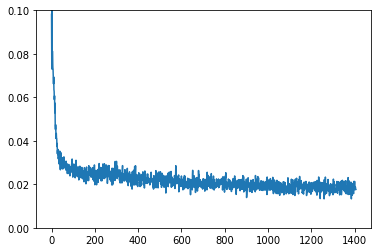

In [63]:
# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 3

# Create the network
net = BasicUNet()
net.to(device)

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3) 

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x)

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1);

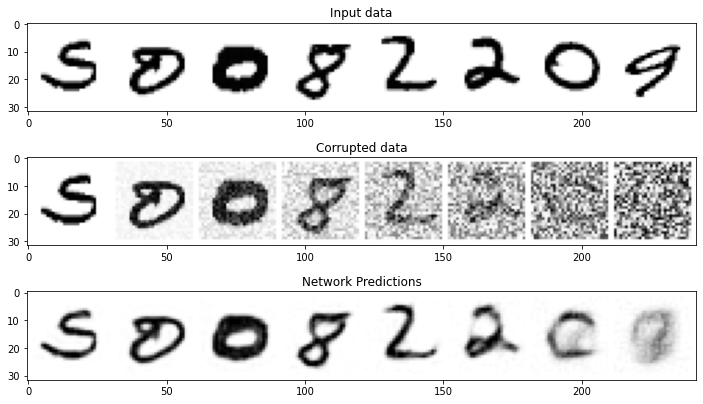

In [64]:
# Fetch some data
x, y = next(iter(train_dl))
x = x[:8] # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Get the model predictions
with torch.no_grad():
  preds = net(noised_x.to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap='Greys')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='Greys');

## 02.05. Sampling

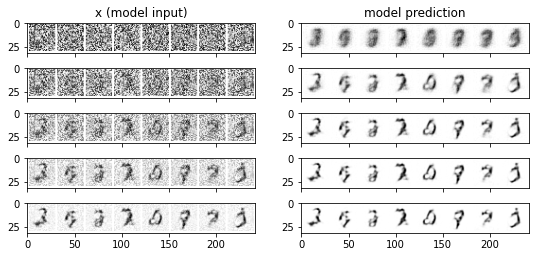

In [65]:
# Sampling strategy: Break the process into 5 steps and move 1/5'th of the way there each time:
n_steps = 5
x = torch.rand(8, 1, 28, 28).to(device) # Start from random
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad(): # No need to track gradients during inference
        pred = net(x) # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu()) # Store model output for plotting
    mix_factor = 1/(n_steps - i) # How much we move towards the prediction
    x = x*(1-mix_factor) + pred*mix_factor # Move part of the way there
    step_history.append(x.detach().cpu()) # Store step for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0,0].set_title('x (model input)')
axs[0,1].set_title('model prediction')
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap='Greys')
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap='Greys')

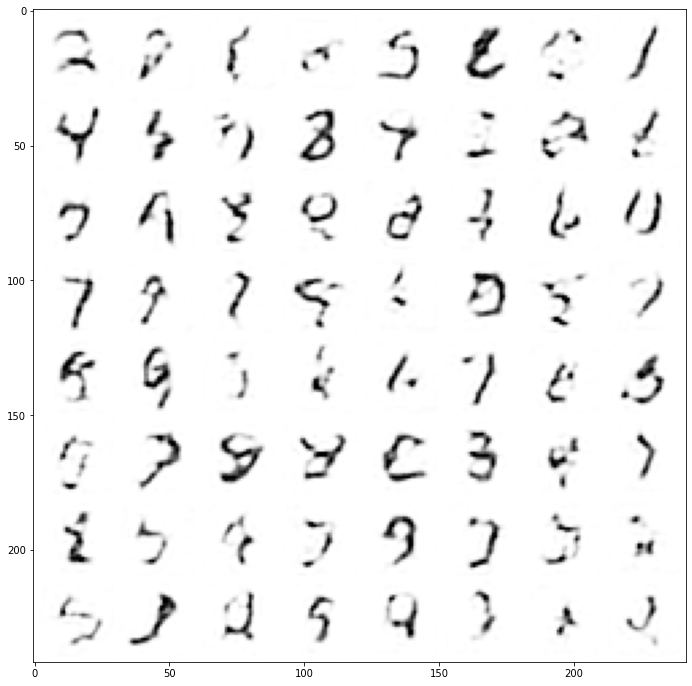

In [66]:
# Showing more results, using 40 sampling steps
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x)
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')